In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Create baseline

In [ ]:
import sys
sys.path.append("../")

from Fairea.fairea import create_baseline
from aif360.datasets import BinaryLabelDataset

dataset_used = "diabetes"
clf_name = "cat"
degrees = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
mutation_strategies = {"0":[1,0],"1":[0,1]}

label_name = 'readmitted'
sensitive_attribute = ['gender_race']

privileged_groups = [{'gender_race': 1}]
unprivileged_groups = [{'gender_race': 0}]

data = pd.read_csv('../data/diabetes_pre/diabetes.csv')

dataset_orig = BinaryLabelDataset(
    df=data,
    label_names=[label_name],
    protected_attribute_names = sensitive_attribute,
    favorable_label = 1,
    unfavorable_label = 0
)

res = create_baseline(clf_name,dataset_orig, privileged_groups,unprivileged_groups,
                    data_splits=10,repetitions=10,odds=mutation_strategies,options = [0,1],
                   degrees = degrees)

c:\Users\enemy\anaconda3\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\enemy\anaconda3\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\enemy\anaconda3\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\enemy\anaconda3\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\enemy\anaconda3\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning:

invalid value encountered in scalar divide



In [9]:
acc0 = np.array([np.mean([row[0] for row in res["0"][degree]]) for degree in degrees])
acc1 = np.array([np.mean([row[0] for row in res["1"][degree]]) for degree in degrees])

spd0 = np.array([np.mean([row[3] for row in res["0"][degree]]) for degree in degrees])
spd1 = np.array([np.mean([row[3] for row in res["1"][degree]]) for degree in degrees])

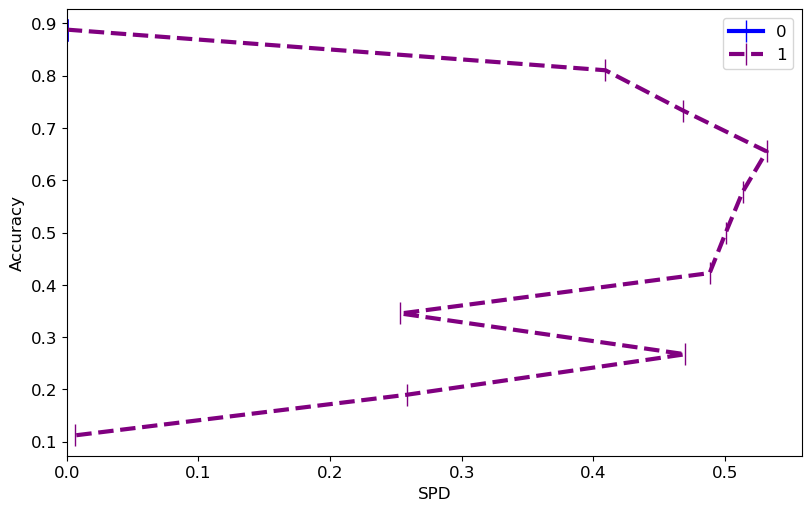

: 

In [ ]:
from shapely.geometry import Polygon, Point, LineString
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5),constrained_layout=True)
axes.plot(spd0,acc0,color="blue",marker = "|", linestyle = "solid",linewidth=3,markersize=16)
axes.plot(spd1,acc1,color="purple",marker = "|", linestyle = "dashed",linewidth=3,markersize=16)
axes.set_xlim(0)
axes.set_xlabel("SPD")
axes.set_ylabel("Accuracy")
axes.legend(mutation_strategies.keys())
plt.show()

### Apply to gridsearch results

In [5]:
df = pd.read_csv('../f_results/diabetes_results.csv')
# df.drop(df[df['fair_score'] == 1].index, inplace = True)
df.head()

,model,BM,balanced_acc,acc,precision,recall,f1,eq_opp_diff,avg_odd_diff,spd,disparate_impact,theil_idx,fair_score
0,AD,inAD,0.571197,0.493299,0.138257,0.671642,0.229311,-0.672847,-0.601929,-0.546952,0.000000,0.094770,1.000
1,AD,baseline,0.591732,0.607545,0.156988,0.571343,0.246300,-0.572368,-0.378156,-0.217666,0.468012,0.108806,1.000
2,AD,preR inAD posC,0.565785,0.630461,0.148094,0.482388,0.226616,0.518541,0.584942,0.636419,2.750416,0.118660,1.000
3,AD,preR inAD posE,0.560376,0.485661,0.134130,0.656716,0.222762,-0.323963,-0.191426,-0.081690,0.851412,0.096177,0.853
4,AD,preR inAD posR,0.504293,0.883811,0.229358,0.014925,0.028027,-0.014952,-0.010657,-0.007327,0.000000,0.119573,0.627


In [ ]:
def plot_tradeoff(df, x_split=0.5, y_split=0.8, diagonal_end=None,
                 region_colors=None, title="Accuracy vs Bias Trade-off Regions"):
    """
    Creates a trade-off plot with dynamic ranges and configurable regions
    """
    # Calculate dynamic ranges with 5% padding
    x_min = max(0, df['fair_score'].min() - 0.05)
    x_max = min(1, df['fair_score'].max() + 0.05)
    y_min = max(0, df['acc'].min() - 0.05)
    y_max = min(1, df['acc'].max() + 0.05)

    # Set default diagonal end if not provided
    if diagonal_end is None:
        diagonal_end = (x_split, y_max)

    # Default colors with high transparency
    colors = {
        'win_win': 'rgba(0,200,0,0.1)',
        'good_tradeoff': 'rgba(100,200,100,0.1)',
        'poor_tradeoff': 'rgba(255,165,0,0.1)',
        'inverted': 'rgba(128,0,128,0.1)',
        'lose_lose': 'rgba(255,0,0,0.1)'
    }
    if region_colors:
        colors.update(region_colors)

    fig = go.Figure()

    # Region coordinates
    left_regions = {
        'base_x': x_min,
        'base_y': y_min,
        'split_x': x_split,
        'split_y': y_split,
        'diag_x': diagonal_end[0],
        'diag_y': diagonal_end[1]
    }

    # Add regions (order matters for layering)
    # Poor Trade-off (rectangle)
    fig.add_shape(type="rect",
        x0=left_regions['base_x'], y0=left_regions['base_y'],
        x1=left_regions['split_x'], y1=left_regions['split_y'],
        fillcolor=colors['poor_tradeoff'], layer="below")

    # Good Trade-off (triangle)
    fig.add_shape(type="path",
        path=f"M {left_regions['base_x']} {left_regions['split_y']} "
             f"L {left_regions['diag_x']} {left_regions['diag_y']} "
             f"L {left_regions['split_x']} {left_regions['split_y']} Z",
        fillcolor=colors['good_tradeoff'], layer="below")

    # Win-Win (triangle)
    fig.add_shape(type="path",
        path=f"M {left_regions['base_x']} {left_regions['split_y']} "
             f"L {left_regions['diag_x']} {left_regions['diag_y']} "
             f"L {left_regions['base_x']} {left_regions['diag_y']} Z",
        fillcolor=colors['win_win'], layer="below")

    # Right regions
    fig.add_shape(type="rect", x0=x_split, y0=y_split, x1=x_max, y1=y_max,
                 fillcolor=colors['inverted'], layer="below")
    fig.add_shape(type="rect", x0=x_split, y0=y_min, x1=x_max, y1=y_split,
                 fillcolor=colors['lose_lose'], layer="below")

    # Add scatter plot
    fig.add_trace(go.Scatter(
        x=df['fair_score'], y=df['acc'],
        mode='markers', marker=dict(size=10, color='blue'),
        name='Models'))

    # Adjusted annotations
    annotations = [
        dict(x=(x_min + x_split)/2, y=.01+(y_split + y_max)/2,
             text="Win-Win", showarrow=False, font=dict(color='darkgreen')),
        dict(x=(x_min + x_split)/2, 
             y=y_split + (left_regions['diag_y'] - y_split)*0.3,  # Adjusted position
             text="Good Trade-off", showarrow=False, font=dict(color='green')),
        dict(x=(x_min + x_split)/2, y=y_min + (y_split - y_min)/2,
             text="Poor Trade-off", showarrow=False, font=dict(color='darkorange')),
        dict(x=(x_split + x_max)/2, y=(y_split + y_max)/2,
             text="Inverted", showarrow=False, font=dict(color='purple')),
        dict(x=(x_split + x_max)/2, y=y_min + (y_split - y_min)/2,
             text="Lose-Lose", showarrow=False, font=dict(color='darkred'))
    ]
    # Find the point with the lowest fairness score
    min_fair_score_row = df.loc[df['fair_score'].idxmin()]
    min_fair_score = min_fair_score_row['fair_score']
    max_acc = min_fair_score_row['acc']
    bm_technique = min_fair_score_row['BM']
    model = min_fair_score_row['model']

    # Highlight the point with the lowest fairness score
    fig.add_trace(
        go.Scatter(
            x=[min_fair_score],
            y=[max_acc],
            mode='markers',
            marker=dict(size=15, color='red', symbol='star',line=dict(width=2,color='DarkSlateGrey')),
            name=f"Best Fairness<br>Model: {model}<br>BM: {bm_technique}",
            showlegend=True
        )
    )

    # Find the point with the highest accuracy score
    max_acc_row = df.loc[df['acc'].idxmax()]
    max_fair_score = max_acc_row['fair_score']
    max_acc = max_acc_row['acc']
    bm_technique = max_acc_row['BM']
    model = max_acc_row['model']

    # Highlight the point with the highest acc score
    fig.add_trace(
        go.Scatter(
            x=[max_fair_score],
            y=[max_acc],
            mode='markers',
            marker=dict(size=15, color='green', symbol='star', line=dict(width=2,color='DarkSlateGrey')),
            name=f"Best Accuracy<br>Model: {model}<br>BM: {bm_technique}",
            showlegend=True
        )
    )

    fig.update_layout(
        title=title,
        xaxis_title="Fair Score",
        yaxis_title="Accuracy",
        xaxis=dict(range=[x_min - 0.05, x_max + 0.05]),
        yaxis=dict(range=[y_min - 0.05, y_max + 0.05]),
        annotations=annotations,
        showlegend=True,
        plot_bgcolor='white',
    )

    return fig

fig = plot_tradeoff(df)
fig.show()

In [7]:
pio.write_image(fig, "fig_stroke_tradeoff.png", width=3*300, height=1.5*300, scale=5)

In [ ]:

# Generate sample data
models = df.model.unique().tolist()
techniques = df['BM'].unique().tolist()

def compress_legend(fig):
    """
    Compresses the legend by grouping traces and simplifying entries.
    Handles cases where trace names do not contain a comma.
    """
    # Extract the first trace's name and check if it contains a comma
    first_trace_name = fig.data[0].name
    if "," in first_trace_name:
        group1_base, group2_base = first_trace_name.split(",")
    else:
        # If no comma, assume the entire name is group1_base and set group2_base to None
        group1_base, group2_base = first_trace_name, None

    lines_marker_name = []

    for i, trace in enumerate(fig.data):
        # Handle cases where trace.name does not contain a comma
        if "," in trace.name:
            part1, part2 = trace.name.split(',')
        else:
            part1, part2 = trace.name, None

        # Process traces based on group1_base and group2_base
        if part1 == group1_base:
            lines_marker_name.append({
                "line": trace.line.to_plotly_json(),
                "marker": trace.marker.to_plotly_json(),
                "mode": trace.mode,
                "name": part2.lstrip(" ") if part2 else ""
            })

        if part2 != group2_base:
            trace['name'] = ''
            trace['showlegend'] = False
        else:
            trace['name'] = part1

    # Update legend layout
    fig.update_layout(
        legend_title_text='',
        legend_itemclick=False,
        legend_itemdoubleclick=False
    )
def create_accuracy_fairness_plot(df, name='WiDS'):
    """
    Creates a scatter plot of Accuracy vs Fairness Score with annotations for BM techniques.
    Highlights the point with the lowest fairness score.
    """
    # Create scatter plot
    fig = px.scatter(
        df,
        x='fair_score',
        y='acc',
        color='model',  # Different colors for classifiers
        title=f'Accuracy vs Fairness Score by Model ({name})',
        labels={
            'fair_score': 'Fairness Score (lower is better)',
            'acc': 'Accuracy'
        },
        height=400
    )

        # Find the point with the lowest fairness score
    min_fair_score_row = df.loc[df['fair_score'].idxmin()]
    min_fair_score = min_fair_score_row['fair_score']
    max_acc = min_fair_score_row['acc']
    bm_technique = min_fair_score_row['BM']
    model = min_fair_score_row['model']

    # Highlight the point with the lowest fairness score
    fig.add_trace(
        go.Scatter(
            x=[min_fair_score],
            y=[max_acc],
            mode='markers',
            marker=dict(size=15, color='red', symbol='star',line=dict(width=2,color='DarkSlateGrey')),
            name=f"Best Fairness<br>Model: {model}<br>BM: {bm_technique}",
            showlegend=True
        )
    )

    # Find the point with the highest accuracy score
    max_acc_row = df.loc[df['acc'].idxmax()]
    max_fair_score = max_acc_row['fair_score']
    max_acc_h = max_acc_row['acc']
    bm_technique = max_acc_row['BM']
    model = max_acc_row['model']

    # Highlight the point with the highest acc score
    fig.add_trace(
        go.Scatter(
            x=[max_fair_score],
            y=[max_acc_h],
            mode='markers',
            marker=dict(size=15, color='green', symbol='star', line=dict(width=2,color='DarkSlateGrey')),
            name=f"Best Accuracy<br>Model: {model}<br>BM: {bm_technique}",
            showlegend=True
        )
    )

    # Add annotation for the bias mitigation technique at the point with the lowest fairness score
    fig.add_annotation(
        x=min_fair_score,
        y=max_acc,
        text=f"BM: {bm_technique}",
        showarrow=True,
        arrowhead=2,
        ax=20,  # Horizontal offset of the arrow
        ay=-40,  # Vertical offset of the arrow
        font=dict(size=12, color="black"),
        bgcolor="white",
        bordercolor="black",
        borderwidth=1
    )

    # Add desired region rectangle
    fig.add_shape(
        type="rect",
        x0=0, y0=0.8,
        x1=0.2, y1=1,
        fillcolor="rgba(0,255,0,0.1)",
        line=dict(width=0),
        layer="below"
    )

    # Add annotation for the desired region
    fig.update_layout(
        annotations=[
            dict(
                x=0.1,
                y=0.9,
                xref="x",
                yref="y",
                text="Desired Region",
                showarrow=False,
                font=dict(size=15)
            )
        ]
    )

    # Compress legend
    compress_legend(fig)

    # Update marker size and font size
    fig.update_traces(marker=dict(size=11))
    fig.update_layout(font=dict(size=16))

    return fig
# Create radar plot for fairness metrics
    
def create_fairness_radar_plot(df):
    # Calculate mean values for each model and mitigation technique
    metrics = ['EOD', 'AOD', 'SPD', 'Theil index', '|1-DI|']
    df['|1-DI|'] = abs(1 - df['DI'])
    
    fig = go.Figure()
    colors = px.colors.qualitative.Set1
    
    for i, (model, group) in enumerate(df.groupby('Model')):
        for technique, subgroup in group.groupby('Bias mitigation technique'):
            values = [subgroup[metric].iloc[0] for metric in metrics[:-1]]
            values.append(subgroup['|1-DI|'].iloc[0])
            
            fig.add_trace(go.Scatterpolar(
                r=values,
                theta=metrics,
                name=f'{model} - {technique}',
                line=dict(color=colors[i]),
                marker=dict(symbol=['circle-open', 'square', 'triangle-up', 'cross', 'star-diamond', 'bowtie','star','hexagon'][
                    techniques.index(technique)]),
            ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 0.4]
            )),
        showlegend=True,
        title='Fairness Metrics Comparison (lower is better)',
        height=600
    )
    
    return fig

In [ ]:
# Create both plots
fig1 = create_accuracy_fairness_plot(df, name='Stroke')
# fig2 = create_accuracy_fairness_plot(df2, name='Stroke')


# Show plots
fig1.show()
pio.write_image(fig1, "fig_wids.png", width=3*300, height=1.5*300, scale=5)
# pio.write_image(fig2, "fig2.png", width=2.5*300, height=1.5*300, scale=5)




In [ ]:
# Create both plots
fig2 = create_fairness_radar_plot(df)

# Show plots
fig2.show()

# Print summary statistics
summary = df.groupby(['Model', 'Bias mitigation technique']).agg({
    'Accuracy': 'mean',
    'Score': 'mean'
}).round(3)
print("\nSummary Statistics:")
print(summary)

In [ ]:
# Define the models, techniques and metrics
metrics = ['EOD', 'AOD', 'SPD', '(1 - DI)']
df['(1 - DI)'] = 1 - df['DI']
df2['(1 - DI)'] = 1 - df2['DI']

# Create the visualization
def plot_fairness_metrics(df, models, techniques, metrics, name='WiDS'):
    # Create subplots
    fig = make_subplots(
        rows=2, 
        cols=3,
        subplot_titles=models,
        vertical_spacing=0.15,
        horizontal_spacing=0.05
    )

    # Color mapping for techniques
    colors = {
        'RW': '#1f77b4',
        'DIR': '#ff7f0e',
        'CEO': '#2ca02c',
        'ROC': '#d62728',
        'RW + CEO': '#9467bd',
        'RW + ROC': '#8c564b',
        'DIR + CEO': '#e377c2',
        'DIR + ROC': '#7f7f7f'
    }

    # Plot each model in its subplot
    for i, model in enumerate(models):
        row = i // 3 + 1
        col = i % 3 + 1
        
        model_data = df[df['Model'] == model]
        
        for technique in techniques:
            technique_data = model_data[model_data['Bias mitigation technique'] == technique]
            
            if not technique_data.empty:
                metric_values = technique_data[metrics].values[0]
                
                fig.add_trace(
                    go.Bar(
                        name=technique,
                        x=metrics,
                        y=metric_values,
                        marker_color=colors[technique],
                        showlegend=True if (i == 0) else False,
                        hovertemplate=(
                            "Model: %s<br>" +
                            "Technique: %s<br>" +
                            "Metric: %%{x}<br>" +
                            "Value: %%{y:.3f}<br>"
                        ) % (model, technique)
                    ),
                    row=row,
                    col=col
                )
                
                fig.add_shape(
                    type="rect",
                    x0=-0.5,  # Extending slightly beyond bar positions
                    x1=2.5,  # Full width of metrics
                    y0=-0.1,  # Lower bound of desired region
                    y1=0.1,   # Upper bound of desired region
                    line=dict(color="green", width=2, dash="dash"),
                    fillcolor="green",
                    opacity=0.05,
                    layer="below",  # Ensure rectangle is behind the bars
                    row=row,
                    col=col
                )

                fig.add_shape(
                    type="rect",
                    x0=2.5,  # Extending slightly beyond bar positions
                    x1=len(metrics)-0.5,  # Full width of metrics
                    y0=-0.2,  # Lower bound of desired region
                    y1=0.2,   # Upper bound of desired region
                    line=dict(color="green", width=2, dash="dash"),
                    fillcolor="green",
                    opacity=0.05,
                    layer="below",  # Ensure rectangle is behind the bars
                    row=row,
                    col=col
                )

    # Update layout
    fig.update_layout(
        height=800,
        width=1500,
        title_text=f"Fairness Metrics Across Different Models and Bias Mitigation Techniques ({name})",
        barmode='group',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.03,
            xanchor="right",
            x=1,
            title=dict(text="Bias Mitigation Techniques")
        ),
        font=dict(size=10)
    )

    # Update axes
    for i in range(1, len(models) + 1):
        # Update x-axes
        fig.update_xaxes(
            tickangle=15,
            row=(i-1)//3 + 1,
            col=(i-1)%3 + 1,
            tickfont=dict(size=8)
        )
        
        # Update y-axes
        fig.update_yaxes(
            range=[-0.9, 0.9],
            row=(i-1)//3 + 1,
            col=(i-1)%3 + 1,
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='black',
            gridcolor='lightgray'
        )

    # Add a common y-axis title
    fig.add_annotation(
        text="Metric Value",
        xref="paper",
        yref="paper",
        x=-0.07,
        y=0.5,
        showarrow=False,
        textangle=-90
    )

    fig.add_annotation(
        x=0,
        y=0.2,
        xref="x",
        yref="y",
        text="Desired Region",
        showarrow=False,
        font=dict(size=15)
    )

    return fig

# Create and display the plot
fig = plot_fairness_metrics(df, models, techniques, metrics, 'WiDS')
fig.show()
pio.write_image(fig, "fair_metrics_wids.png", width=3.5*300, height=2.5*300, scale=5)

In [ ]:
df_baseline = pd.read_excel('./farzaneh_data.xlsx', sheet_name='baseline-Stroke')
df_BM = pd.read_excel('./farzaneh_data.xlsx', sheet_name='pre-post-Stroke')

models = df_BM.Model.unique().tolist()

df_baseline = df_baseline.T.loc[:, df_baseline.T.columns.intersection([0,7])]
df_baseline.columns = df_baseline.iloc[0]
df_baseline = df_baseline[1:]
df_baseline.reset_index()

In [ ]:
df_baseline.Accuracy.max()

In [ ]:
from plotly.subplots import make_subplots
# Create figure with two subplots, one above the other
fig = make_subplots(
    rows=2, 
    cols=1, 
    # subplot_titles=('Accuracy Metric', 'Fairness Metric'),
    vertical_spacing=0.1
)
# Color palette
color_palette = px.colors.qualitative.Plotly

# Accuracy Subplot - Model Boxplots
for i, model in enumerate(models):
    acc_data = df_BM[df_BM.Model == model]
    fig.add_trace(
        go.Box(
            y=acc_data.Accuracy,
            name=model,
            boxpoints='outliers',
            marker_color=color_palette[i],
            opacity=0.7
        ),
        row=1, 
        col=1
    )

# Add Accuracy Baseline (once)
fig.add_trace(
    go.Scatter(
        x=[model for model in models],
        y=df_baseline.Accuracy,
        mode='lines+markers',
        name='Baseline Accuracy',
        line=dict(color='red', width=3, dash='dash'),
        marker=dict(size=10, symbol='star'),
    ),
    row=1, 
    col=1
)

fig.add_shape(
    type="rect",
    x0=-1,  # Extending slightly beyond bar positions
    x1=7,  # Full width of metrics
    y0=df_BM.Accuracy.max(),  # Lower bound of desired region
    y1=df_BM.Accuracy.max(),   # Upper bound of desired region
    line=dict(color="green", width=2,),
    fillcolor="green",
    opacity=0.2,
    layer="below",  # Ensure rectangle is behind the bars
    row=1,
    col=1
)
fig.add_annotation(
    x=-.5,
    y=0.9,
    xref="x",
    yref="y",
    text="best",
    showarrow=False,
    font=dict(size=10),
    row=1,
    col=1
)
fig.add_annotation(
    x=-.5,
    y=0.34,
    xref="x",
    yref="y",
    text="worst",
    showarrow=False,
    font=dict(size=10),
    row=1,
    col=1
)

fig.add_shape(
    type="rect",
    x0=-1,  # Extending slightly beyond bar positions
    x1=7,  # Full width of metrics
    y0=df_BM.Accuracy.nsmallest(2).iloc[-1],  # Lower bound of desired region
    y1=df_BM.Accuracy.nsmallest(2).iloc[-1],   # Upper bound of desired region
    line=dict(color="red", width=2,),
    fillcolor="red",
    opacity=0.2,
    layer="below",  # Ensure rectangle is behind the bars
    row=1,
    col=1
)
# Fairness Subplot - Model Boxplots
for i, model in enumerate(models):
    fair_data = df_BM[df_BM.Model == model]

    fig.add_trace(
        go.Box(
            y=fair_data.Score,
            name=model,
            boxpoints='outliers',
            marker_color=color_palette[i],
            opacity=0.7,
            showlegend=False  # Prevents duplicate legend entries

        ),
        row=2, 
        col=1
    )

# Add Fairness Baseline (once)
fig.add_trace(
    go.Scatter(
        x=[model for model in models],
        y=df_baseline.Score,
        mode='lines+markers',
        name='Baseline Fairness',
        line=dict(color='green', width=3, dash='dash'),
        marker=dict(size=10, symbol='star'),
    ),
    row=2, 
    col=1
)
fig.add_shape(
    type="rect",
    x0=-1,  # Extending slightly beyond bar positions
    x1=7,  # Full width of metrics
    y0=df_BM.Score.min(),  # Lower bound of desired region
    y1=df_BM.Score.min(),   # Upper bound of desired region
    line=dict(color="green", width=2,),
    fillcolor="green",
    opacity=0.2,
    layer="below",  # Ensure rectangle is behind the bars
    row=2,
    col=1
)
fig.add_shape(
    type="rect",
    x0=-1,  # Extending slightly beyond bar positions
    x1=7,  # Full width of metrics
    y0=2.8,  # Lower bound of desired region
    y1=2.8,   # Upper bound of desired region
    line=dict(color="red", width=2,),
    fillcolor="red",
    opacity=0.2,
    layer="below",  # Ensure rectangle is behind the bars
    row=2,
    col=1
)

fig.add_annotation(
    x=-.5,
    y=0.2,
    xref="x",
    yref="y",
    text="best",
    showarrow=False,
    font=dict(size=10),
    row=2,
    col=1
)
fig.add_annotation(
    x=-.5,
    y=2.7,
    xref="x",
    yref="y",
    text="worst",
    showarrow=False,
    font=dict(size=10),
    row=2,
    col=1
)

# Update layout
fig.update_layout(
    title='Classifier Performance: Accuracy and Fairness (Stroke)',
    height=900,
    width=1000,
    showlegend=True
)

# Update y-axis ranges and labels
fig.update_yaxes(
    title_text="Accuracy", 
    row=1, 
    col=1,
    range=[0.3, 0.93]  # Adjusted range for accuracy (assuming scores are between 0.6 and 1.0)
)
fig.update_yaxes(
    title_text="Fairness Score", 
    row=2, 
    col=1,
    range=[0.0,2.9]    # Adjusted range for fairness (assuming scores are between 0 and 1.0)
)
# After creating the figure and before fig.show()
fig.update_xaxes(
    showticklabels=False,
    row=1, col=1  # For accuracy subplot
)
fig.update_xaxes(
    showticklabels=False,
    row=2, col=1  # For fairness subplot
)

# Show the plot
fig.show()
pio.write_image(fig, "fig4_1.png", width=3.5*300, height=2.5*300, scale=5)